In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# base_path = '/media/anant/data/amazon_from_space/'
base_path = '/media/avemuri/DEV/Data/amazon_from_space/'

In [3]:
train_df = pd.read_csv(base_path+'train_v2.csv')
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [4]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in train_df['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))

There is 17 unique labels including {'selective_logging', 'road', 'clear', 'haze', 'slash_burn', 'blooming', 'agriculture', 'water', 'artisinal_mine', 'primary', 'cloudy', 'habitation', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'blow_down', 'cultivation'}


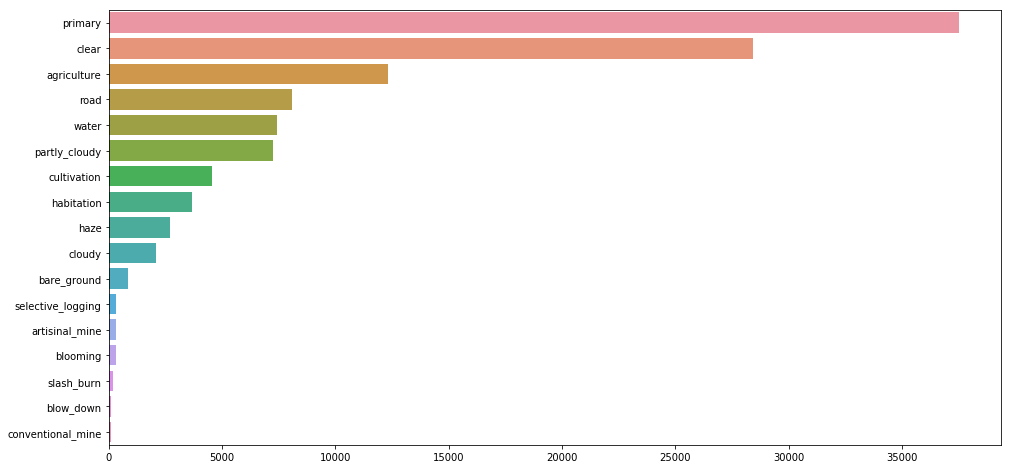

In [5]:
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

In [6]:
weights = labels_s.values/labels_s.values.sum()
print(weights, labels_s.index)

[0.32261477 0.24450885 0.10590997 0.06941124 0.06373519 0.06244517
 0.03910456 0.03147629 0.02319441 0.01796557 0.00741327 0.00292403
 0.00291543 0.00285523 0.00179742 0.00086861 0.00086001] Index(['primary', 'clear', 'agriculture', 'road', 'water', 'partly_cloudy',
       'cultivation', 'habitation', 'haze', 'cloudy', 'bare_ground',
       'selective_logging', 'artisinal_mine', 'blooming', 'slash_burn',
       'blow_down', 'conventional_mine'],
      dtype='object')


In [7]:
index = ['conventional_mine', 'road', 'habitation', 'primary', 'cloudy', 'cultivation', 'partly_cloudy', 'artisinal_mine', 'selective_logging', 'blooming', 'agriculture', 'water', 'bare_ground', 'blow_down', 'slash_burn', 'clear', 'haze']
labels_s.reindex(index)
weights = labels_s.values/labels_s.values.sum()
print(weights, labels_s.index)

conventional_mine      100
road                  8071
habitation            3660
primary              37513
cloudy                2089
cultivation           4547
partly_cloudy         7261
artisinal_mine         339
selective_logging      340
blooming               332
agriculture          12315
water                 7411
bare_ground            862
blow_down              101
slash_burn             209
clear                28431
haze                  2697
dtype: int64

[0.32261477 0.24450885 0.10590997 0.06941124 0.06373519 0.06244517
 0.03910456 0.03147629 0.02319441 0.01796557 0.00741327 0.00292403
 0.00291543 0.00285523 0.00179742 0.00086861 0.00086001] Index(['primary', 'clear', 'agriculture', 'road', 'water', 'partly_cloudy',
       'cultivation', 'habitation', 'haze', 'cloudy', 'bare_ground',
       'selective_logging', 'artisinal_mine', 'blooming', 'slash_burn',
       'blow_down', 'conventional_mine'],
      dtype='object')


In [8]:
print(labels_s)

primary              37513
clear                28431
agriculture          12315
road                  8071
water                 7411
partly_cloudy         7261
cultivation           4547
habitation            3660
haze                  2697
cloudy                2089
bare_ground            862
selective_logging      340
artisinal_mine         339
blooming               332
slash_burn             209
blow_down              101
conventional_mine      100
dtype: int64


In [9]:
reindexed = labels_s.reindex(index)

In [10]:
print(reindexed)
weights = 10*reindexed.values/reindexed.values.sum()
print(weights)

conventional_mine      100
road                  8071
habitation            3660
primary              37513
cloudy                2089
cultivation           4547
partly_cloudy         7261
artisinal_mine         339
selective_logging      340
blooming               332
agriculture          12315
water                 7411
bare_ground            862
blow_down              101
slash_burn             209
clear                28431
haze                  2697
dtype: int64
[0.00860008 0.69411239 0.3147629  3.22614768 0.17965565 0.3910456
 0.62445174 0.02915427 0.02924027 0.02855226 1.05909974 0.63735186
 0.07413268 0.00868608 0.01797417 2.44508849 0.23194413]


In [11]:
# for ival in index

In [12]:
import glob
import cv2
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, fbeta_score
from tqdm import tqdm_notebook, tqdm


import tensorflow.keras as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [13]:
image_list = [f for f in glob.glob(base_path+'train-jpg/*.jpg')]
print(len(image_list))

40479


In [14]:
X = []
y = []


df_train = pd.read_csv(base_path+'train_v2.csv')

flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.imread(base_path+'train-jpg/'+'{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    X.append(cv2.resize(img, (32, 32)))
    y.append(targets)
    
y = np.array(y, np.uint8)
X = np.array(X, np.float16) / 255.

print(X.shape)
print(y.shape)

100%|██████████| 40479/40479 [00:49<00:00, 814.34it/s]


(40479, 32, 32, 3)
(40479, 17)


In [43]:
SPLIT = 0.2
dataset_size = len(X)
indices = list(range(dataset_size))
split = int(np.floor(SPLIT * dataset_size))

np.random.seed(42)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]
x_train, x_valid, y_train, y_valid = X[train_indices], X[val_indices], y[train_indices], y[val_indices]
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(32384, 32, 32, 3) (32384, 17) (8095, 32, 32, 3) (8095, 17)


In [44]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(32, 32, 3)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

In [45]:
class KerasMetrics:
	def precision(self, y_true, y_pred):
		true_positives = k.backend.sum(k.backend.round(k.backend.clip(y_true * y_pred, 0, 1)))
		predicted_positives = k.backend.sum(k.backend.round(k.backend.clip(y_pred, 0, 1)))
		precision = true_positives / (predicted_positives + k.backend.epsilon())
		return precision

	def recall(self, y_true, y_pred):
		true_positives = k.backend.sum(k.backend.round(k.backend.clip(y_true * y_pred, 0, 1)))
		possible_positives = k.backend.sum(k.backend.round(k.backend.clip(y_true, 0, 1)))
		recall = true_positives / (possible_positives + k.backend.epsilon())
		return recall

	def fbeta_score(self, y_true, y_pred, beta=2):
		if beta < 0:
			raise ValueError('The lowest choosable beta is zero (only precision).')

		if k.backend.sum(k.backend.round(k.backend.clip(y_true, 0, 1))) == 0:
			return 0

		p = self.precision(y_true, y_pred)
		r = self.recall(y_true, y_pred)
		bb = beta ** 2
		fbeta_score = (1 + bb) * (p * r) / (bb * p + r + k.backend.epsilon())
		return fbeta_score

In [46]:
keras_metrics = KerasMetrics()
# We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
optim = k.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy', keras_metrics.fbeta_score])

In [47]:
datagen = k.preprocessing.image.ImageDataGenerator(width_shift_range=0.2,
                                                   height_shift_range=0.2,
                                                   vertical_flip=True)

datagen.fit(x_train)

In [48]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=256),
                              steps_per_epoch=len(x_train) / 256, epochs=50,
                              validation_data=(x_valid, y_valid))

Epoch 1/50
127/126 [==============================] - 13s 105ms/step - loss: 0.3110 - acc: 0.8815 - fbeta_score: 0.5843 - val_loss: 0.2408 - val_acc: 0.9066 - val_fbeta_score: 0.6085
Epoch 2/50
127/126 [==============================] - 12s 92ms/step - loss: 0.2448 - acc: 0.9065 - fbeta_score: 0.6052 - val_loss: 0.2196 - val_acc: 0.9143 - val_fbeta_score: 0.6356
Epoch 3/50
127/126 [==============================] - 13s 101ms/step - loss: 0.2266 - acc: 0.9125 - fbeta_score: 0.6306 - val_loss: 0.2051 - val_acc: 0.9184 - val_fbeta_score: 0.6546
Epoch 4/50
127/126 [==============================] - 12s 96ms/step - loss: 0.2196 - acc: 0.9146 - fbeta_score: 0.6401 - val_loss: 0.1994 - val_acc: 0.9209 - val_fbeta_score: 0.6634
Epoch 5/50
127/126 [==============================] - 12s 92ms/step - loss: 0.2116 - acc: 0.9164 - fbeta_score: 0.6534 - val_loss: 0.1931 - val_acc: 0.9220 - val_fbeta_score: 0.6901
Epoch 6/50
127/126 [==============================] - 12s 95ms/step - loss: 0.2037 - acc

In [34]:
history = model.fit(x_train, y_train,
                    batch_size=256,
                    epochs=50,
                    verbose=1,
                    validation_data=(x_valid, y_valid))

Train on 32384 samples, validate on 8095 samples
Epoch 1/50
32384/32384 [==============================] - 3s 91us/sample - loss: 0.2963 - acc: 0.8893 - fbeta_score: 0.5768 - val_loss: 0.2270 - val_acc: 0.9104 - val_fbeta_score: 0.5898
Epoch 2/50
32384/32384 [==============================] - 3s 78us/sample - loss: 0.2305 - acc: 0.9101 - fbeta_score: 0.6182 - val_loss: 0.2028 - val_acc: 0.9197 - val_fbeta_score: 0.6600
Epoch 3/50
32384/32384 [==============================] - 3s 79us/sample - loss: 0.2081 - acc: 0.9191 - fbeta_score: 0.6755 - val_loss: 0.1974 - val_acc: 0.9209 - val_fbeta_score: 0.7195
Epoch 4/50
32384/32384 [==============================] - 2s 76us/sample - loss: 0.1902 - acc: 0.9264 - fbeta_score: 0.7109 - val_loss: 0.1721 - val_acc: 0.9327 - val_fbeta_score: 0.7470
Epoch 5/50
32384/32384 [==============================] - 2s 75us/sample - loss: 0.1793 - acc: 0.9300 - fbeta_score: 0.7274 - val_loss: 0.1713 - val_acc: 0.9326 - val_fbeta_score: 0.7535
Epoch 6/50
32384

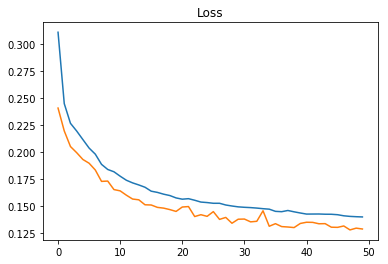

In [49]:
_ = plt.plot(history.history['loss'], label='Train')
_ = plt.plot(history.history['val_loss'], label='Validation')
_ = plt.title('Loss')

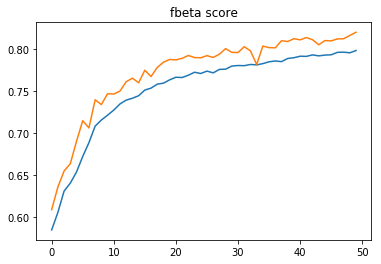

In [50]:
_ = plt.plot(history.history['fbeta_score'], label='Train')
_ = plt.plot(history.history['val_fbeta_score'], label='Validation')
_ = plt.title('fbeta score')

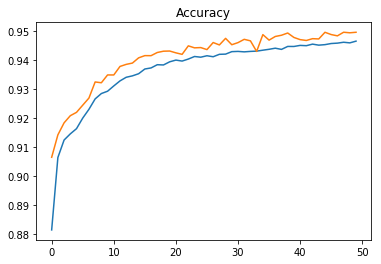

In [51]:
_ = plt.plot(history.history['acc'], label='Train')
_ = plt.plot(history.history['val_acc'], label='Validation')
_ = plt.title('Accuracy')

In [22]:
class DataGenerator(k.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[idx] for idx in indexes]

        # Generate data
        #X, y = self.__data_generation(list_IDs_temp)

        #return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

#     def __data_generation(self, list_IDs_temp):
#         'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
#         # Initialization
#         X = np.empty((self.batch_size, *self.dim, self.n_channels))
#         y = np.empty((self.batch_size), dtype=int)

#         # Generate data
#         for i, ID in enumerate(list_IDs_temp):
#             # Store sample
#             X[i,] = np.load('data/' + ID + '.npy')

#             # Store class
#             y[i] = self.labels[ID]

#         return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
gen = DataGenerator()

In [ ]:
def csv_image_generator(inputPath, bs, lb, mode="train", aug=None):
	# open the CSV file for reading
	f = open(inputPath, "r")

	# loop indefinitely
	while True:
		# initialize our batches of images and labels
		images = []
		labels = []

		# keep looping until we reach our batch size
		while len(images) < bs:
			# attempt to read the next line of the CSV file
			line = f.readline()

			# check to see if the line is empty, indicating we have
			# reached the end of the file
			if line == "":
				# reset the file pointer to the beginning of the file
				# and re-read the line
				f.seek(0)
				line = f.readline()

				# if we are evaluating we should now break from our
				# loop to ensure we don't continue to fill up the
				# batch from samples at the beginning of the file
				if mode == "eval":
					break

			# extract the label and construct the image
			line = line.strip().split(",")
			label = line[0]
			image = np.array([int(x) for x in line[1:]], dtype="uint8")
			image = image.reshape((64, 64, 3))

			# update our corresponding batches lists
			images.append(image)
			labels.append(label)

		# one-hot encode the labels
		labels = lb.transform(np.array(labels))

		# if the data augmentation object is not None, apply it
		if aug is not None:
			(images, labels) = next(aug.flow(np.array(images),
				labels, batch_size=bs))

		# yield the batch to the calling function
		yield (np.array(images), labels)